<a href="https://colab.research.google.com/github/GEMCorp/CropDamage-Prediction/blob/main/AAKTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# To Do

## A brief explanation of approach including;

   1. Any data pre-processing performed.

   2. Your chosen ML model with justification.

   3. Performance evaluation of the chosen model and obtained results.

   4. Comparison with the performance of other ML models where relevant.

# Loading the dataset

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
dataset_directory = '/content/drive/My Drive/AAKTP'

In [3]:
import os
os.listdir(dataset_directory)

['train_crop.csv',
 'test_crop.xlsx',
 'Task_Harvest Evaluation using Machine Learning.docx']

# Preprocessing and EDA

## Importing libraries for data cleaning and EDA

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sb

## Examining and understanding content of the data

In [5]:
train_dataframe = pd.read_csv(dataset_directory + '/train_crop.csv')

In [7]:
train_dataframe.shape

(88858, 10)

In [8]:
train_dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88858 entries, 0 to 88857
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       88858 non-null  object 
 1   Estimated_Insects_Count  88858 non-null  int64  
 2   Crop_Type                88858 non-null  int64  
 3   Soil_Type                88858 non-null  int64  
 4   Pesticide_Use_Category   88858 non-null  int64  
 5   Number_Doses_Week        88858 non-null  int64  
 6   Number_Weeks_Used        79858 non-null  float64
 7   Number_Weeks_Quit        88858 non-null  int64  
 8   Season                   88858 non-null  int64  
 9   Crop_Damage              88858 non-null  int64  
dtypes: float64(1), int64(8), object(1)
memory usage: 6.8+ MB


Dataset contains 10 columns with various data types which can provide a very rich amount of information for data exploration.Also it can be seen already that number of weeks used has some missing values which will require cleaning.

In [9]:
train_dataframe.describe() # works for ints and floats

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
count,88858.000000,88858.000000,88858.000000,88858.000000,88858.000000,79858.000000,88858.000000,88858.000000,88858.000000
mean,1399.012210,0.284375,0.458417,2.264186,25.849952,28.623970,9.589986,1.896959,0.190562
std,849.048781,0.451119,0.498271,0.461772,15.554428,12.391881,9.900631,0.701322,0.454215
min,150.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
25%,731.000000,0.000000,0.000000,2.000000,15.000000,20.000000,0.000000,1.000000,0.000000
50%,1212.000000,0.000000,0.000000,2.000000,20.000000,28.000000,7.000000,2.000000,0.000000
75%,1898.000000,1.000000,1.000000,3.000000,40.000000,37.000000,16.000000,2.000000,0.000000
max,4097.000000,1.000000,1.000000,3.000000,95.000000,67.000000,50.000000,3.000000,2.000000


In [10]:
train_dataframe.describe(include=object) #including objects

,ID
count,88858
unique,88858
top,F00000001
freq,1


In [11]:
train_dataframe

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1
...,...,...,...,...,...,...,...,...,...,...
88853,F00155935,3337,1,0,2,10,12.0,44,3,0
88854,F00155938,3516,1,0,2,10,20.0,38,1,0
88855,F00155939,3516,1,0,2,15,40.0,8,2,0
88856,F00155942,3702,1,0,2,10,25.0,18,3,0


In [12]:
train_dataframe.isnull().sum()

ID                            0
Estimated_Insects_Count       0
Crop_Type                     0
Soil_Type                     0
Pesticide_Use_Category        0
Number_Doses_Week             0
Number_Weeks_Used          9000
Number_Weeks_Quit             0
Season                        0
Crop_Damage                   0
dtype: int64

## Cleaning The Data

Categorical features and target are already ordinalEncoded, NaN values and standardization needs to be done. Find some correlation between number of weeks used and other features/target to determine dropping or imputing. No need for discretization and non-linear transformation. Might have to use polynomial features later.

In [13]:
# manually inspecting to for any obvious correllation
train_dataframe[train_dataframe.Number_Weeks_Used.isnull()]

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
5,F00000008,448,0,1,1,0,NaN,0,2,1
6,F00000009,448,0,1,1,0,NaN,0,2,1
10,F00000021,1212,1,0,1,0,NaN,0,3,0
17,F00000037,2401,0,1,1,0,NaN,0,1,1
35,F00000076,257,0,0,3,30,NaN,0,2,0
...,...,...,...,...,...,...,...,...,...,...
88786,F00155793,1785,1,0,2,60,NaN,16,2,0
88788,F00155801,1898,1,0,2,15,NaN,3,1,0
88825,F00155882,2542,1,0,2,10,NaN,21,2,0
88833,F00155899,2687,1,0,2,10,NaN,21,2,0


<Axes: xlabel='Pesticide_Use_Category', ylabel='count'>

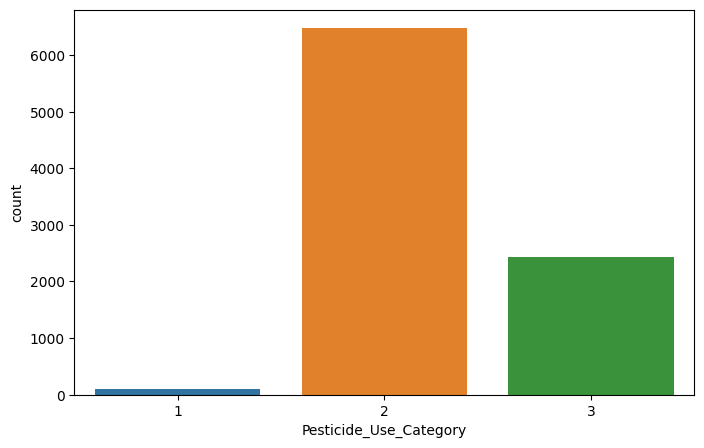

In [14]:
NaN_df = train_dataframe[train_dataframe.Number_Weeks_Used.isnull()]

# countplot of pesticide category when weeks_used is NaN
plt.figure(figsize=(8, 5))
sb.countplot(x=NaN_df['Pesticide_Use_Category'])

In [15]:
# Make case for no correlation calculation when NaN present
# After manual inpection + count plot shows that whenever pesticide type 1, number of weeks used is O but has value whenever pesticide type 2 or 3.
# And so we fill with mean.

In [6]:
mean = train_dataframe['Number_Weeks_Used'].mean()

# Define a function to apply the conditions and fill NaN values
def fill_nan(row):
    if pd.isna(row['Number_Weeks_Used']):
        if row['Pesticide_Use_Category'] == 1:
            return 0
        elif row['Pesticide_Use_Category'] == 2 or row['Pesticide_Use_Category'] == 3:
            return mean
    return row['Number_Weeks_Used']

# Apply the function to the column
train_dataframe['Number_Weeks_Used'] = train_dataframe.apply(fill_nan, axis=1) # same as train_dataframe['Number_Weeks_Used'].apply(lambda x: fill_nan(x))

In [17]:
train_dataframe.head(15) # inspect after filling of NaN values

,ID,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,F00000001,188,1,0,1,0,0.0,0,1,0
1,F00000003,209,1,0,1,0,0.0,0,2,1
2,F00000004,257,1,0,1,0,0.0,0,2,1
3,F00000005,257,1,1,1,0,0.0,0,2,1
4,F00000006,342,1,0,1,0,0.0,0,2,1
5,F00000008,448,0,1,1,0,0.0,0,2,1
6,F00000009,448,0,1,1,0,0.0,0,2,1
7,F00000010,577,1,0,1,0,0.0,0,1,2
8,F00000012,731,0,0,1,0,0.0,0,2,0
9,F00000020,1132,1,0,1,0,0.0,0,1,2


In [7]:
#drop ID too : no information content, can lead to overfitting (rand), dimentionality reduction and model efficiency
train_dataframe.drop('ID', axis=1, inplace=True)

In [19]:
train_dataframe

,Estimated_Insects_Count,Crop_Type,Soil_Type,Pesticide_Use_Category,Number_Doses_Week,Number_Weeks_Used,Number_Weeks_Quit,Season,Crop_Damage
0,188,1,0,1,0,0.0,0,1,0
1,209,1,0,1,0,0.0,0,2,1
2,257,1,0,1,0,0.0,0,2,1
3,257,1,1,1,0,0.0,0,2,1
4,342,1,0,1,0,0.0,0,2,1
...,...,...,...,...,...,...,...,...,...
88853,3337,1,0,2,10,12.0,44,3,0
88854,3516,1,0,2,10,20.0,38,1,0
88855,3516,1,0,2,15,40.0,8,2,0
88856,3702,1,0,2,10,25.0,18,3,0


## Exploratory Data Analysis

<Axes: xlabel='Crop_Damage', ylabel='count'>

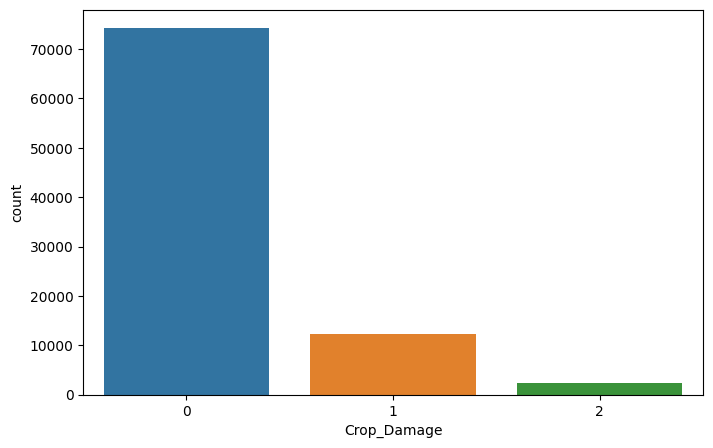

In [20]:
# countplot of crop damage : Looking at class frequencies
plt.figure(figsize=(8, 5))
sb.countplot(x=train_dataframe['Crop_Damage'])

### Looking for correlation

#### With Point Biserial Correlation Coefficient

In [21]:
# Edit later to make it work

import scipy.stats as stats


for feature in train_dataframe.columns:
    if feature != 'Crop_Damage':
        for class_label in train_dataframe['Crop_Damage'].unique():
            class_data = train_dataframe[train_dataframe['Crop_Damage'] == class_label][feature]
            correlation, p_value = stats.pointbiserialr(class_data, train_dataframe[train_dataframe['Crop_Damage'] == class_label]['Crop_Damage'])
            print(f'Feature: {feature}, Class: {class_label}, Correlation: {correlation}, p-value: {p_value}')


Feature: Estimated_Insects_Count, Class: 0, Correlation: nan, p-value: nan
Feature: Estimated_Insects_Count, Class: 1, Correlation: nan, p-value: nan
Feature: Estimated_Insects_Count, Class: 2, Correlation: nan, p-value: nan
Feature: Crop_Type, Class: 0, Correlation: nan, p-value: nan
Feature: Crop_Type, Class: 1, Correlation: nan, p-value: nan
Feature: Crop_Type, Class: 2, Correlation: nan, p-value: nan
Feature: Soil_Type, Class: 0, Correlation: nan, p-value: nan
Feature: Soil_Type, Class: 1, Correlation: nan, p-value: nan
Feature: Soil_Type, Class: 2, Correlation: nan, p-value: nan
Feature: Pesticide_Use_Category, Class: 0, Correlation: nan, p-value: nan
Feature: Pesticide_Use_Category, Class: 1, Correlation: nan, p-value: nan
Feature: Pesticide_Use_Category, Class: 2, Correlation: nan, p-value: nan
Feature: Number_Doses_Week, Class: 0, Correlation: nan, p-value: nan
Feature: Number_Doses_Week, Class: 1, Correlation: nan, p-value: nan
Feature: Number_Doses_Week, Class: 2, Correlation

/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4781: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


#### With Random Forest Classifier

In [22]:
from sklearn.ensemble import RandomForestClassifier

X = train_dataframe.drop('Crop_Damage', axis=1)
y = train_dataframe['Crop_Damage']

# Train a Random Forest Classifier
clf = RandomForestClassifier()
clf.fit(X, y)

feature_importances = clf.feature_importances_
for feature, importance in zip(X.columns, feature_importances):
    print(f'Feature: {feature}, Importance: {importance}')


Feature: Estimated_Insects_Count, Importance: 0.32070493380448983
Feature: Crop_Type, Importance: 0.011088527381761788
Feature: Soil_Type, Importance: 0.015039005842727906
Feature: Pesticide_Use_Category, Importance: 0.03203372703454131
Feature: Number_Doses_Week, Importance: 0.14708934453358755
Feature: Number_Weeks_Used, Importance: 0.28320684909987454
Feature: Number_Weeks_Quit, Importance: 0.14993674882616825
Feature: Season, Importance: 0.04090086347684888


# Model selection

## Feature Scaling and Mean Normalization

In [23]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, PolynomialFeatures # might need polynomial features to avoid overfitting

In [24]:
X = train_dataframe.drop('Crop_Damage', axis=1)
y = train_dataframe['Crop_Damage']

In [25]:
#with normalization, gradient descent can converge more quickly
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [26]:
#may run after cross validation if metrics shows underfitting
# quad = PolynomialFeatures(interaction_only=True, include_bias=False)#default degree of 2
# X_train = quad.fit_transform(X_train)
# X_test = quad.fit_transform(X_test)

Put this [image](https://scikit-learn.org/stable/_static/ml_map.png) from [sklearn docs](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html) about model selection in slides

## Building a dummy classifier

As shown [ealier](https://colab.research.google.com/drive/1OJHKy-OCOb2X35JXQI0WBBnonMAGGojw#scrollTo=klAOMeKdlYKI&line=3&uniqifier=1), most of the crop are not damaged and so we have a skewed data. This can as well be visualized in percentages.

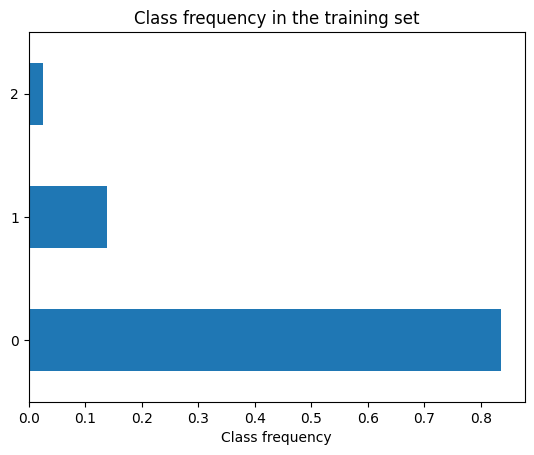

In [27]:
y.value_counts(normalize=True).plot.barh()
plt.xlabel("Class frequency")
_ = plt.title("Class frequency in the training set")

In [28]:
# from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, shuffle=True, test_size=0.33, random_state=42
#     ) # turns our pd df to np arrays,

In [29]:
# from sklearn.dummy import DummyClassifier

# dummy_classifier = DummyClassifier(strategy="most_frequent")
# dummy_classifier.fit(X, y)
# print(
#     "Accuracy of the dummy classifier: "
#     f"{dummy_classifier.score(X_test, y_test):.3f}"
# )

In [30]:
# target_predicted = dummy_classifier.predict(X_test)

In [31]:
# from sklearn.metrics import ConfusionMatrixDisplay

# _ = ConfusionMatrixDisplay.from_estimator(dummy_classifier, X_test, y_test)

In [32]:
# from sklearn.metrics import balanced_accuracy_score

# balanced_accuracy = balanced_accuracy_score(y_test, target_predicted)
# print(f"Balanced accuracy: {balanced_accuracy:.3f}")

In [33]:
# from sklearn.model_selection import StratifiedKFold, GridSearchCV

In [34]:
# skfold_cv = StratifiedKFold() #defaults to 5 splits
# for train_index, test_index in skfold_cv.split(X, y):
#   X_train, X_test = X[train_index], X[test_index]
#   y_train, y_test = y[train_index], y[test_index]

# # yet to make use the kfold created

# # using a nested cv here
# from sklearn.model_selection import GridSearchCV
# from sklearn.svm import SVC

# param_grid = {"C": [0.1, 1, 10], "gamma": [0.01, 0.1]}
# model_to_tune = SVC()

# search = GridSearchCV(estimator=model_to_tune, param_grid=param_grid, n_jobs=2)
# search.fit(data, target)

# from sklearn.model_selection import cross_val_score, KFold

# # Declare the inner and outer cross-validation strategies
# inner_cv = KFold(n_splits=5, shuffle=True, random_state=0)
# outer_cv = KFold(n_splits=3, shuffle=True, random_state=0)

# # Inner cross-validation for parameter search
# model = GridSearchCV(
#     estimator=model_to_tune, param_grid=param_grid, cv=inner_cv, n_jobs=2
# )

# # Outer cross-validation to compute the testing score
# test_score = cross_val_score(model, data, target, cv=outer_cv, n_jobs=2)
# print(
#     "The mean score using nested cross-validation is: "
#     f"{test_score.mean():.3f} ± {test_score.std():.3f}"
# )

## Buiding baseline models

### Hyperparameter tuning

In [7]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
# from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

X = train_dataframe.drop('Crop_Damage', axis=1)
y = train_dataframe['Crop_Damage']


# It's good practice to scale your data for these algorithms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


# Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define models and the hyperparameters to tune
model_params = {
    'Logistic Regression': {
        'model': LogisticRegression(random_state=42),
        'params': {
            'C': [0.1, 1, 10, 100],
            'solver': ['newton-cg', 'lbfgs', 'liblinear']
        }
    },
    # 'LinearSVC': {
    #     'model': CalibratedClassifierCV(LinearSVC(random_state=42), cv=3),
    #     'params': {
    #         'base_estimator__C': [0.1, 1, 10, 100]  # base_estimator__ prefix for CalibratedClassifierCV
    #     }
    # },
    'K Neighbors Classifier': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance'],
            'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
        }
    }
}

# Conduct grid search for each model
for name, mp in model_params.items():
    clf = GridSearchCV(
        estimator=mp['model'],
        param_grid=mp['params'],
        cv=skf,
        scoring='f1_weighted',  # Assuming a multi-class classification problem
        n_jobs=-1,
        verbose=2
    )

    print(f'Tuning {name}...')
    clf.fit(X_scaled, y)
    print(f'Best parameters for {name}: {clf.best_params_}')
    print(f'Best score for {name}: {clf.best_score_:.4f}\n')


Tuning Logistic Regression...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters for Logistic Regression: {'C': 0.1, 'solver': 'liblinear'}
Best score for Logistic Regression: 0.7726

Tuning K Neighbors Classifier...
Fitting 5 folds for each of 32 candidates, totalling 160 fits
Best parameters for K Neighbors Classifier: {'algorithm': 'auto', 'n_neighbors': 9, 'weights': 'uniform'}
Best score for K Neighbors Classifier: 0.8018



In [8]:
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.calibration import CalibratedClassifierCV

X = train_dataframe.drop('Crop_Damage', axis=1)
y = train_dataframe['Crop_Damage']


# It's good practice to scale your data for these algorithms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define models
models = {
    'Logistic Regression': LogisticRegression(n_jobs=-1, random_state=42),
    'LinearSVC': CalibratedClassifierCV(LinearSVC(random_state=42), cv=3, n_jobs=-1),
    'K Neighbors Classifier': KNeighborsClassifier(n_neighbors=9, n_jobs=-1)
}

# Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    f1_scores, precision_scores, recall_scores = [], [], []

    for fold_num, (train_index, test_index) in enumerate(skf.split(X_scaled, y), 1):
        print(f"Processing Fold {fold_num} for {name}")  # Debugging print statement for folds

        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print(f'Training {name}...')  # Debugging print statement
        model.fit(X_train, y_train)
        print(f'Trained {name}!')  # Debugging print statement

        y_pred = model.predict(X_test)

        # Assuming a multi-class classification problem
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))

    print(f'Model: {name}')
    print(f'F1 Score: {sum(f1_scores) / len(f1_scores):.4f}')
    print(f'Precision: {sum(precision_scores) / len(precision_scores):.4f}')
    print(f'Recall: {sum(recall_scores) / len(recall_scores):.4f}\n')


Processing Fold 1 for Logistic Regression
Training Logistic Regression...
Trained Logistic Regression!
Processing Fold 2 for Logistic Regression
Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained Logistic Regression!
Processing Fold 3 for Logistic Regression
Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained Logistic Regression!
Processing Fold 4 for Logistic Regression
Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained Logistic Regression!
Processing Fold 5 for Logistic Regression
Training Logistic Regression...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained Logistic Regression!
Model: Logistic Regression
F1 Score: 0.7721
Precision: 0.7584
Recall: 0.8333

Processing Fold 1 for LinearSVC
Training LinearSVC...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained LinearSVC!
Processing Fold 2 for LinearSVC
Training LinearSVC...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained LinearSVC!
Processing Fold 3 for LinearSVC
Training LinearSVC...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained LinearSVC!
Processing Fold 4 for LinearSVC
Training LinearSVC...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained LinearSVC!
Processing Fold 5 for LinearSVC
Training LinearSVC...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained LinearSVC!
Model: LinearSVC
F1 Score: 0.7726
Precision: 0.7583
Recall: 0.8331

Processing Fold 1 for K Neighbors Classifier
Training K Neighbors Classifier...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Trained K Neighbors Classifier!
Processing Fold 2 for K Neighbors Classifier
Training K Neighbors Classifier...
Trained K Neighbors Classifier!
Processing Fold 3 for K Neighbors Classifier
Training K Neighbors Classifier...
Trained K Neighbors Classifier!
Processing Fold 4 for K Neighbors Classifier
Training K Neighbors Classifier...
Trained K Neighbors Classifier!
Processing Fold 5 for K Neighbors Classifier
Training K Neighbors Classifier...
Trained K Neighbors Classifier!
Model: K Neighbors Classifier
F1 Score: 0.8018
Precision: 0.7893
Recall: 0.8366



In [ ]:
# from sklearn.model_selection import StratifiedKFold
# from sklearn.linear_model import LogisticRegression
# from sklearn.svm import SVC, LinearSVC
# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.neighbors import NeighborhoodComponentsAnalysis
# from sklearn.pipeline import Pipeline
# from sklearn.metrics import f1_score

# # Set up StratifiedKFold
# skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# # Initialize models
# models = {
#     'Logistic_Regression': LogisticRegression(multi_class='ovr', random_state=42),
#     'SVC': SVC(decision_function_shape='ovr', random_state=42, probability=True),
#     'lSVC': LinearSVC(),
#     'K_Neighbors_Classifier': Pipeline([
#         ('nca', NeighborhoodComponentsAnalysis(random_state=42)),
#         ('knn', KNeighborsClassifier())
#     ])
# }

# # Initialize a dictionary to hold the F1 scores for each model
# f1_scores = {model: [] for model in models}

# # Perform StratifiedKFold cross-validation
# for train_index, test_index in skf.split(X, y):
#     X_train, X_test = X[train_index], X[test_index]
#     y_train, y_test = y[train_index], y[test_index]

#     for model_name, model in models.items():
#         model.fit(X_train, y_train)
#         y_pred = model.predict(X_test)
#         f1 = f1_score(y_test, y_pred, average='micro')  # Change average as needed ('micro', 'weighted')
#         f1_scores[model_name].append(f1)

# # Calculate the mean F1 score for each model across the folds
# mean_f1_scores = {model: np.mean(scores) for model, scores in f1_scores.items()}
# print(mean_f1_scores)


In [ ]:
# from sklearn import svm

# Svc = svm.SVC(decision_function_shape='ovr')
# Svc.fit(X_train, y_train)

In [ ]:
# from sklearn.svm import LinearSVC
# # from sklearn.pipeline import make_pipeline
# # from sklearn.preprocessing import StandardScaler
# # from sklearn.datasets import make_classification
# # X, y = make_classification(n_features=4, random_state=0)

# lSvc = LinearSVC(dual="auto", tol=1e-5)
# lSvc.fit(X_train, y_train)

In [ ]:
# from sklearn.inspection import DecisionBoundaryDisplay


# def plot_training_data_with_decision_boundary(kernel, clf):
#     # # Train the SVC
#     # clf = svm.SVC(kernel=kernel, gamma=2).fit(X, y)

#     # Settings for plotting
#     _, ax = plt.subplots(figsize=(4, 3))
#     x_min, x_max, y_min, y_max = -3, 3, -3, 3
#     ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

#     # Plot decision boundary and margins
#     common_params = {"estimator": clf, "X": X, "ax": ax}
#     DecisionBoundaryDisplay.from_estimator(
#         **common_params,
#         response_method="predict",
#         plot_method="pcolormesh",
#         alpha=0.3,
#     )
#     DecisionBoundaryDisplay.from_estimator(
#         **common_params,
#         response_method="decision_function",
#         plot_method="contour",
#         levels=[-1, 0, 1],
#         colors=["k", "k", "k"],
#         linestyles=["--", "-", "--"],
#     )

#     # Plot bigger circles around samples that serve as support vectors
#     ax.scatter(
#         clf.support_vectors_[:, 0],
#         clf.support_vectors_[:, 1],
#         s=250,
#         facecolors="none",
#         edgecolors="k",
#     )
#     # Plot samples by color and add legend
#     ax.scatter(X, y, c=y, s=150, edgecolors="k")
#     ax.legend(*scatter.legend_elements(), loc="upper right", title="Classes")
#     ax.set_title(f" Decision boundaries of {kernel} kernel in SVC")

#     _ = plt.show()

In [ ]:
# plot_training_data_with_decision_boundary(kernel="rbf", clf=SVC)

In [ ]:
# plot_training_data_with_decision_boundary(kernel="rbf", clf=lSVC)

In [ ]:
# from sklearn import

In [ ]:
# # Create an instance of Logistic Regression Classifier and fit the data.
# logreg = LogisticRegression(C=1e5, multi_class='ovr')
# logreg.fit(X_train, y_train)

# _, ax = plt.subplots(figsize=(4, 3))
# DecisionBoundaryDisplay.from_estimator(
#     Logistic_Regression,
#     X,
#     cmap=plt.cm.Paired,
#     ax=ax,
#     response_method="predict",
#     plot_method="pcolormesh",
#     shading="auto",
#     xlabel="Sepal length",
#     ylabel="Sepal width",
#     eps=0.5,
# )

# # Plot also the training points
# plt.scatter(X, y, c=Y, edgecolors="k", cmap=plt.cm.Paired)


# plt.xticks(())
# plt.yticks(())

# plt.show()


In [ ]:
# !pip install mlxtend

In [10]:
# from mlxtend.plotting import plot_decision_regions  # may need to install this package via pip

In [ ]:
# # Plotting decision boundaries
# # selected only two features for simplicity
# # X_values = X[['Estimated_Insects_Count', 'Season']].values  # place features of choice here
# X_values = X.values
# y_values = y.values

# # # Initialize models
# # models = {
# #     'Logistic_Regression': LogisticRegression(C=1e5, multi_class='ovr', max_iter=10000, random_state=42),
# #     'SVC': SVC(decision_function_shape='ovr', random_state=42),
# #     'lSVC': LinearSVC(dual="auto", tol=1e-5),
# #     'K_Neighbors_Classifier': Pipeline([
# #         ('nca', NeighborhoodComponentsAnalysis(random_state=42)),
# #         ('knn', KNeighborsClassifier())
# #     ])
# # }
# value=1.5
# width=0.75

# # plot decision boundaries
# for model_name, model in models.items():
#     # model.fit(X_values, y_values)

#     plt.figure()
#     plot_decision_regions(
#         X_values, y_values, clf=model,
#         feature_index=[0,7],
#         filler_feature_values={1:value, 2: value, 3:value, 4:value, 5:value, 6: value, 7:value},
#         filler_feature_ranges={1:value, 2: value, 3:value, 4:value, 5:value, 6: value, 7:value},
#         legend=2)
#     plt.title(f'Decision Boundary for {model_name}')
#     plt.show()


In [ ]:
# from sklearn.neighbors import (NeighborhoodComponentsAnalysis,
# KNeighborsClassifier)
# # from sklearn.datasets import load_iris
# # from sklearn.model_selection import train_test_split
# from sklearn.pipeline import Pipeline
# # X, y = load_iris(return_X_y=True)
# # X_train, X_test, y_train, y_test = train_test_split(X, y,
# # stratify=y, test_size=0.7, random_state=42)
# nca = NeighborhoodComponentsAnalysis(random_state=42)
# knn = KNeighborsClassifier() # default n_neighbors=5
# nca_pipe = Pipeline([('nca', nca), ('knn', knn)])
# nca_pipe.fit(X_train, y_train)
# print(nca_pipe.score(X_test, y_test)) # let see what we do here

## Ensembling models for generalizability / robustness

In [ ]:
# Random Forest, Gradient Boosting (e.g., XGBoost, LightGBM),

In [ ]:
# These dont seem like ensembling. merge with baselines code
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb

# Assuming df is your DataFrame
df = pd.read_csv('your_data.csv')  # replace 'your_data.csv' with your data file

X = df.iloc[:, :-1]  # assuming target is the last column
y = df.iloc[:, -1]

# It's good practice to scale your data for these algorithms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Define models
models = {
    'XGBoost': xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_jobs=-1, random_state=42),
    'LightGBM': lgb.LGBMClassifier(n_jobs=-1, random_state=42),
    'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=42)
}

# Stratified K-Folds cross-validator
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, model in models.items():
    f1_scores, precision_scores, recall_scores = [], [], []

    for fold_num, (train_index, test_index) in enumerate(skf.split(X_scaled, y), 1):
        print(f"Processing Fold {fold_num} for {name}")  # Debugging print statement for folds

        X_train, X_test = X_scaled[train_index], X_scaled[test_index]
        y_train, y_test = y[train_index], y[test_index]

        print(f'Training {name}...')  # Debugging print statement
        model.fit(X_train, y_train)
        print(f'Trained {name}!')  # Debugging print statement

        y_pred = model.predict(X_test)

        # Assuming a multi-class classification problem
        f1_scores.append(f1_score(y_test, y_pred, average='weighted'))
        precision_scores.append(precision_score(y_test, y_pred, average='weighted'))
        recall_scores.append(recall_score(y_test, y_pred, average='weighted'))

    print(f'Model: {name}')
    print(f'F1 Score: {sum(f1_scores) / len(f1_scores):.4f}')
    print(f'Precision: {sum(precision_scores) / len(precision_scores):.4f}')
    print(f'Recall: {sum(recall_scores) / len(recall_scores):.4f}\n')


In [ ]:
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NeighborhoodComponentsAnalysis
from sklearn.ensemble import StackingClassifier

# Assuming df is your DataFrame
df = pd.read_csv('your_dataset.csv')  # Replace with your dataset path

X = df.drop('target', axis=1)
y = df['target']

# Set up StratifiedKFold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define base models
base_models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000, random_state=42)),
    ('SVC', SVC(random_state=42, probability=True)),  # probability=True is required for stacking
    ('K Neighbors Classifier', Pipeline([
        ('nca', NeighborhoodComponentsAnalysis()),
        ('knn', KNeighborsClassifier())
    ]))
]

# Define stacking ensemble
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)

# Initialize a dictionary to hold the F1 scores for each model and the ensemble
f1_scores = {model[0]: [] for model in base_models}
f1_scores['Stacking Ensemble'] = []

# Perform StratifiedKFold cross-validation
for train_index, test_index in skf.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Fit and evaluate base models
    for model_name, model in base_models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        f1 = f1_score(y_test, y_pred, average='binary')  # Change average as needed
        f1_scores[model_name].append(f1)

    # Fit and evaluate stacking ensemble
    stacking_model.fit(X_train, y_train)
    y_pred = stacking_model.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='binary')  # Change average as needed
    f1_scores['Stacking Ensemble'].append(f1)

# Calculate the mean F1 score for each model and the ensemble across the folds
mean_f1_scores = {model: np.mean(scores) for model, scores in f1_scores.items()}
print(mean_f1_scores)


In [ ]:
import matplotlib.pyplot as plt
from sklearn.ensemble import StackingClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.decomposition import NeighborhoodComponentsAnalysis
from mlxtend.plotting import plot_decision_regions
import pandas as pd
import numpy as np

# Assuming df is your DataFrame
df = pd.read_csv('your_dataset.csv')  # Replace with your dataset path

X = df[['feature1', 'feature2']].values  # replace 'feature1' and 'feature2' with the names of your features
y = df['target'].values

# Define base models
base_models = [
    ('Logistic Regression', LogisticRegression(max_iter=10000, random_state=42)),
    ('SVC', SVC(random_state=42, probability=True)),  # probability=True is required for stacking
    ('K Neighbors Classifier', Pipeline([
        ('nca', NeighborhoodComponentsAnalysis()),
        ('knn', KNeighborsClassifier())
    ]))
]

# Define stacking ensemble
stacking_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)

# Fit models and plot decision boundaries
for model_name, model in base_models:
    model.fit(X, y)
    plt.figure()
    plot_decision_regions(X, y, clf=model, legend=2)
    plt.title(f'Decision Boundary for {model_name}')
    plt.show()

# Fit and plot decision boundary for stacking ensemble
stacking_model.fit(X, y)
plt.figure()
plot_decision_regions(X, y, clf=stacking_model, legend=2)
plt.title('Decision Boundary for Stacking Ensemble')
plt.show()


# Model evaluation and comparison